In [1]:
#1. Import all dependencies

import requests
import csv

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=10, 5

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [2]:
#2. Initialise some key variables

api_key = "QLCIP4Y92EACB30U"
stock_symbol = "SONACOMS"

In [3]:
#3. Get the updated stock history data using the public api endpoint

# Website used to get historical data: https://www.alphavantage.co/
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock_symbol}.BSE&datatype=csv&outputsize=full&apikey={api_key}'
r = requests.get(url)

## API Results
data = r.text

## Write API Results to CSV
with open('data.csv', "w") as csvFile:
    csvFile.write(data)

df=pd.read_csv('data.csv')
df.head()

,timestamp,open,high,low,close,volume
0,2023-08-18,567.30,576.80,564.85,566.40,101112
1,2023-08-17,565.30,572.00,555.00,567.25,55079
2,2023-08-16,545.45,560.05,545.45,554.10,49433
3,2023-08-14,553.05,553.45,535.50,549.40,31893
4,2023-08-11,560.75,560.75,553.70,555.35,47097


In [4]:
#4. Split the data into train/test

train_fraction = int(0.7*df.shape[0])
train_fraction

373

In [5]:
#5. Correlation of different columns in the dataset

correlation = df.corr(numeric_only = True)
correlation

,open,high,low,close,volume
open,1.000000,0.992637,0.994106,0.989888,-0.053916
high,0.992637,1.000000,0.991014,0.995425,-0.050681
low,0.994106,0.991014,1.000000,0.995074,-0.058130
close,0.989888,0.995425,0.995074,1.000000,-0.056942
volume,-0.053916,-0.050681,-0.058130,-0.056942,1.000000


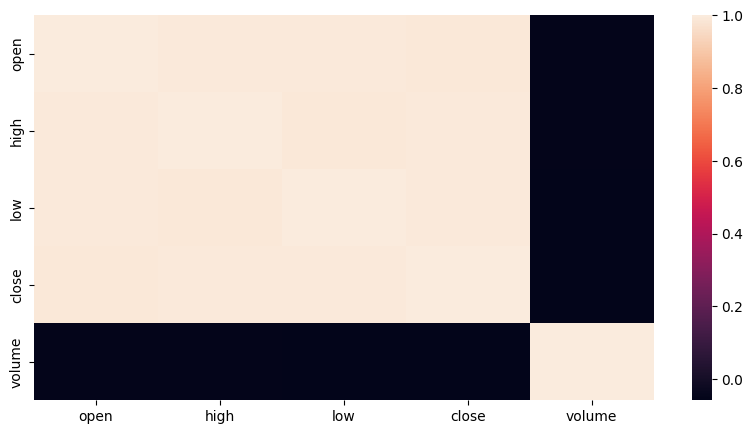

<Figure size 400x200 with 0 Axes>

In [6]:
#6. Plot the heatmap for correlation of different columns in the dataset

sns.heatmap(correlation)
plt.figure(figsize=(4, 2))
plt.show()

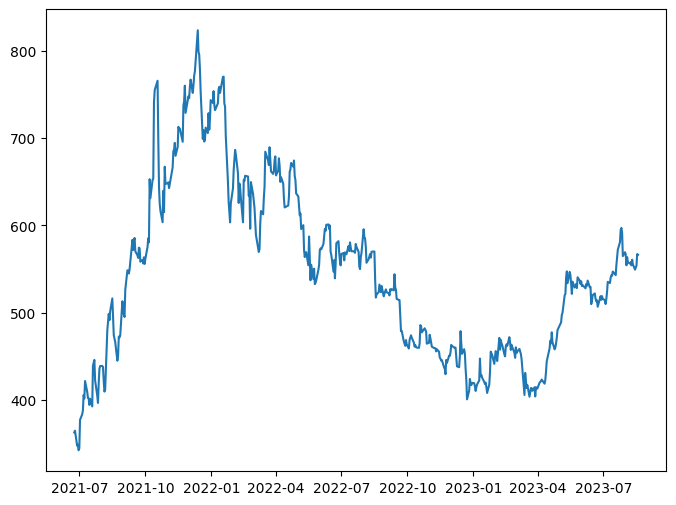

In [7]:
#7. Analyze the closing prices from dataframe

df["Date"]=pd.to_datetime(df.timestamp,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(8,6))
plt.plot(df["close"],label='Close Price history')

In [8]:
#8. Sort the dataset on date time and filter “Date” and “Close” columns
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["close"][i]

In [9]:
#9. Normalize the new filtered dataset
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["close"][i]


new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values

train_data=final_dataset[0:train_fraction,:]
valid_data=final_dataset[train_fraction:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [10]:
#10. Build and train the LSTM model

lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=10,batch_size=1,verbose=2)

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

Epoch 1/10
313/313 - 19s - loss: 0.0119 - 19s/epoch - 61ms/step
Epoch 2/10
313/313 - 4s - loss: 0.0065 - 4s/epoch - 12ms/step
Epoch 3/10
313/313 - 4s - loss: 0.0051 - 4s/epoch - 12ms/step
Epoch 4/10
313/313 - 5s - loss: 0.0048 - 5s/epoch - 16ms/step
Epoch 5/10
313/313 - 4s - loss: 0.0037 - 4s/epoch - 12ms/step
Epoch 6/10
313/313 - 4s - loss: 0.0028 - 4s/epoch - 12ms/step
Epoch 7/10
313/313 - 3s - loss: 0.0023 - 3s/epoch - 11ms/step
Epoch 8/10
313/313 - 2s - loss: 0.0020 - 2s/epoch - 7ms/step
Epoch 9/10
313/313 - 2s - loss: 0.0020 - 2s/epoch - 7ms/step
Epoch 10/10
313/313 - 2s - loss: 0.0022 - 2s/epoch - 7ms/step


In [11]:
#11. Take a sample of a dataset to make stock price predictions using the LSTM model

X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price=lstm_model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

6/6 [==============================] - 1s 5ms/step


In [12]:
#12. Save the LSTM model

lstm_model.save("saved_lstm_model.h5")

MSE OF THE MODEL:  137.69051043389445
RMSE OF THE MODEL:  11.734159979900328


<ipython-input-13-18114eb7c18d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=closing_price


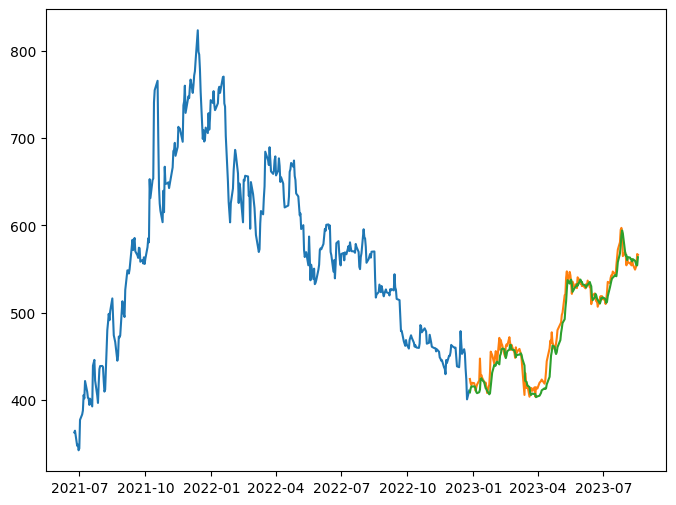

In [13]:
#13. Visualize the predicted stock costs with actual stock costs

train_data=new_dataset[:train_fraction]
valid_data=new_dataset[train_fraction:]
valid_data['Predictions']=closing_price
actual_price = valid_data['Close']

# using metrics module for error calculation
mse = metrics.mean_squared_error(actual_price, closing_price)
rmse = mse**.5
print("MSE OF THE MODEL: ", mse)
print("RMSE OF THE MODEL: ", rmse)

plt.figure(figsize=(8,6))
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])

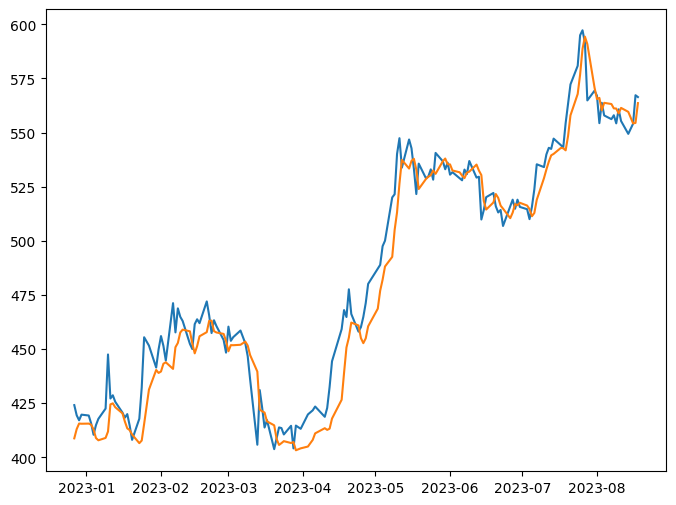

In [14]:
#14. Visualize the predicted stock costs with actual stock costs

plt.figure(figsize=(8,6))
plt.plot(valid_data[['Close',"Predictions"]])